In [2]:
from scipy.linalg import lu_factor, lu_solve
import numpy as np

def get_Ginv(self, energy):
    """The inverse of the retarded surface Green function"""
    z = self.z(energy)

    v_00 = z * self.S.T.conj() - self.H.T.conj()
    v_11 = v_00.copy()
    v_10 = z * self.s_ij - self.h_ij
    v_01 = z * self.s_ij.T.conj() - self.h_ij.T.conj()
    delta = self.conv + 1
    while delta > self.conv:
        lu, piv = lu_factor(v_11, check_finite=False)
        a = lu_solve((lu, piv), v_01, check_finite=False)
        b = lu_solve((lu, piv), v_10, check_finite=False)
        v_01_dot_b = np.dot(v_01, b)
        v_00 -= v_01_dot_b
        v_11 -= np.dot(v_10, a)
        v_11 -= v_01_dot_b
        v_01 = -np.dot(v_01, a)
        v_10 = -np.dot(v_10, b)
        delta = abs(v_01).max()
    return v_00

### Overview of the code

- The above code snippet shows the computation of the surface Green's function using the recursive Sancho-Rubio algorithm. H and S are the Hamiltonian and overlap matrices of the lead, and z is the energy grid for which one wants to compute the transmission function, with a small shift onto the imaginary plane to help with convergence. For a given iteration "n",
 
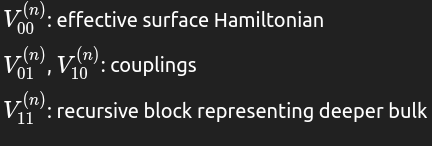


- `v_00` will eventually hold the effective Hamiltonian of the surface layer dressed by the effect of the semi-infinite leads. `v_11` holds the interior block (i.e. the rest of the semi-infinite leads).

- ```v_11 = v_00.copy()``` - This line tells you that at the beginning of the iteration, it will approximate the interior of the leads to be identical to the surface of the leads. One iteration of the recursion modifies 

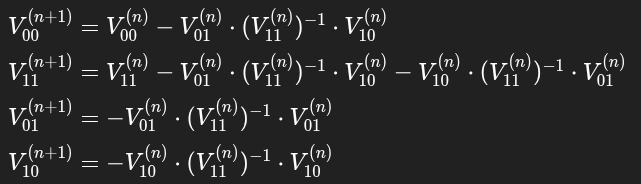

- As the recursion proceeds, `v_11` evolves to represent deeper and deeper parts of the bulk. The recursion therefore updates `v_00` with more and more bulk layers via `v_11` until convergence. Convergence is checked using `delta` which quantifies how much the off-diagonal interlayer coupling `v_01` changes. Once it falls below a certain user-defined convergence threshold, it indicates that the surface layer has effectively decoupled from deeper layers. Therefore, adding more layers doesn't significantly change the effective coupling and the recursion can safely end. 

### Coding tricks in the algorithm and how they relate to the mathematical form

The code snippet contains the following:
```
lu, piv = lu_factor(v_11, check_finite=False)
a = lu_solve((lu, piv), v_01, check_finite=False)
b = lu_solve((lu, piv), v_10, check_finite=False)
```

- Why do this and how does it relate to any of the formulas in the recursion?
  - In the recursion formula, you see that we're repeatedly doing 
  
   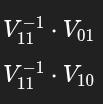 

  - Instead of inverting `v_11` directly, which is expensive and numerically unstable, we use the trick of `lu_solve` which allows us to solve linear equations of the form
  
  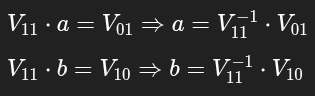

  - I haven't looked too deeply into scipy's `lu_solve` and `lu_factor` but these libraries solve for a and b without ever explicitly inverting `v_11`. It is based on an LU decomposition algorithm that I've not looked closely into.

### Preparing the leads matrices for computing self-energy

```
nkpts_leads = (6, 1, 1)

# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = map(lambda m: m[0], prepare_leads_matrices(
    H_k_leads,
    S_k_leads,
    nkpts_leads,
    align=(0, H_device[0, 0]),
))
```

What does `align` do?

It computes the shift in the Hamiltonian of the leads required to align the 0th orbital of the lead to the 0th orbital of the device using

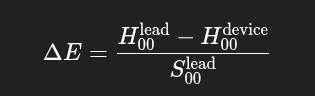

This energy shift is applied to all elements of the leads Hamiltonian and ensures that the lead Hamiltonian is on the same energy scale as the device Hamiltonian. This is probably not required in the case of a tight-binding Hamiltonian. But when using DFT, since the lead and device are computed separately, this is required.